
# Soil EDA & Machine Learning for Rice 🌾

This notebook:
- Loads **`crop_yield_dataset.csv`**
- Filters rows where `Crop_Type` is **rice** (falls back to full dataset if none)
- Calculates **% of nutrient targets** for rice (N/P/K) and plots a bar chart
- Runs **EDA** (summary stats, correlation heatmap, N,P,K distributions)
- Trains **Linear Regression** and **Random Forest** models to predict `Crop_Yield`
- Saves outputs (plots & CSVs) to `./outputs/`


In [76]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

# Notebook display options
pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"] = (6,4)
print("Imports loaded.")


Imports loaded.


In [58]:
# ---------------- CONFIG ----------------
CSV_PATH = Path("crop_yield_dataset.csv")
OUTDIR = Path("clean_outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Column expectations (adjust if your schema differs)
DATE_COL = "Date"
CAT_COLS = ["Crop_Type", "Soil_Type"]
NUM_COLS = ["Soil_pH", "Temperature", "Humidity", "Wind_Speed", "N", "P", "K", "Crop_Yield"]

# Plausible ranges (domain heuristics; tweak for your region/units)
RANGES = {
    "Soil_pH": (3.0, 10.0),
    "Temperature": (-10.0, 60.0),  # °C
    "Humidity": (0.0, 100.0),      # %
    "Wind_Speed": (0.0, 60.0),     # set per your units
    "N": (0.0, np.inf),
    "P": (0.0, np.inf),
    "K": (0.0, np.inf),
    "Crop_Yield": (0.0, np.inf),
}

# Outlier handling
APPLY_WINSORIZE = True   # set False to only report, not clip
IQR_FACTOR = 1.5         # Tukey fences

plt.rcParams["figure.figsize"] = (6, 4)
pd.set_option("display.max_columns", 120)

print("Config loaded. Outputs ->", OUTDIR.resolve())


Config loaded. Outputs -> D:\Deep Learning Project\Soil_quality_data\clean_outputs


In [60]:
df_raw = pd.read_csv(CSV_PATH)
print("Raw shape:", df_raw.shape)
df_raw.head(10)


Raw shape: (36520, 12)


,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,2014-01-01,Wheat,Peaty,5.50,9.440599,80.000000,10.956707,60.5,45.0,31.5,0.000000,22.833333
1,2014-01-01,Corn,Loamy,6.50,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
2,2014-01-01,Rice,Peaty,5.50,12.143099,80.000000,7.227751,71.5,54.0,38.5,0.000000,27.333333
3,2014-01-01,Barley,Sandy,6.75,19.751848,80.000000,2.682683,50.0,40.0,30.0,58.939796,35.000000
4,2014-01-01,Soybean,Peaty,5.50,16.110395,80.000000,7.696070,49.5,45.0,38.5,32.970413,22.166667
5,2014-01-01,Cotton,Sandy,6.75,14.826739,80.000000,10.366657,55.0,44.0,36.0,29.356115,39.375000
6,2014-01-01,Sugarcane,Saline,8.00,13.533004,80.000000,9.910484,84.5,66.0,54.0,0.000000,17.041667
7,2014-01-01,Tomato,Clay,6.25,18.323272,80.000000,8.198084,60.0,45.0,40.0,22.221375,42.291667
8,2014-01-01,Potato,Peaty,5.50,18.895963,80.000000,6.696707,60.5,45.0,31.5,54.259727,22.833333
9,2014-01-01,Sunflower,Loamy,6.50,16.865595,80.000000,9.311649,70.0,66.0,55.0,68.119250,63.666667


In [62]:
def plot_missing_bars(df, title, out_path):
    miss = df.isna().sum().sort_values(ascending=False)
    plt.figure(figsize=(8, 4))
    plt.bar(miss.index.astype(str), miss.values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Missing count")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()

def iqr_bounds(series, iqr_factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - iqr_factor * iqr
    high = q3 + iqr_factor * iqr
    return low, high


In [64]:
df = df_raw.copy()

# 1) Trim/lowercase categorical columns
for c in CAT_COLS:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower().replace({"nan": np.nan})

# 2) Parse date if present
if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# 3) Coerce numeric columns
for c in NUM_COLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("After type normalization:", df.shape)
df.head(10)


After type normalization: (36520, 12)


,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,2014-01-01,wheat,peaty,5.50,9.440599,80.000000,10.956707,60.5,45.0,31.5,0.000000,22.833333
1,2014-01-01,corn,loamy,6.50,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
2,2014-01-01,rice,peaty,5.50,12.143099,80.000000,7.227751,71.5,54.0,38.5,0.000000,27.333333
3,2014-01-01,barley,sandy,6.75,19.751848,80.000000,2.682683,50.0,40.0,30.0,58.939796,35.000000
4,2014-01-01,soybean,peaty,5.50,16.110395,80.000000,7.696070,49.5,45.0,38.5,32.970413,22.166667
5,2014-01-01,cotton,sandy,6.75,14.826739,80.000000,10.366657,55.0,44.0,36.0,29.356115,39.375000
6,2014-01-01,sugarcane,saline,8.00,13.533004,80.000000,9.910484,84.5,66.0,54.0,0.000000,17.041667
7,2014-01-01,tomato,clay,6.25,18.323272,80.000000,8.198084,60.0,45.0,40.0,22.221375,42.291667
8,2014-01-01,potato,peaty,5.50,18.895963,80.000000,6.696707,60.5,45.0,31.5,54.259727,22.833333
9,2014-01-01,sunflower,loamy,6.50,16.865595,80.000000,9.311649,70.0,66.0,55.0,68.119250,63.666667


In [66]:
dup_count = df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)
print(f"Removed duplicates: {dup_count}. New shape: {df.shape}")


Removed duplicates: 0. New shape: (36520, 12)


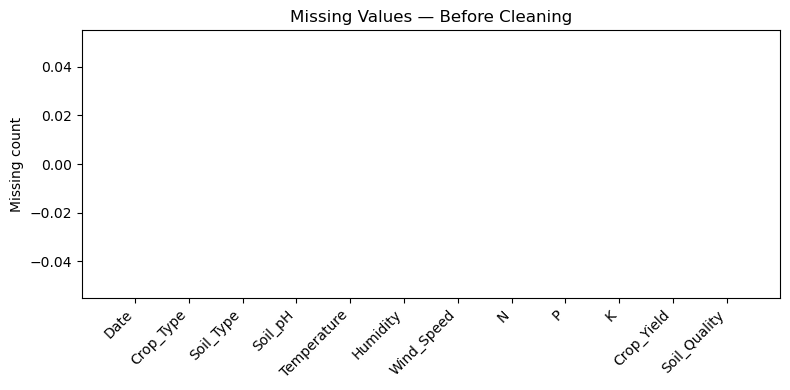

Saved: clean_outputs\missing_before.png


Date            0
Crop_Type       0
Soil_Type       0
Soil_pH         0
Temperature     0
Humidity        0
Wind_Speed      0
N               0
P               0
K               0
Crop_Yield      0
Soil_Quality    0
dtype: int64

In [68]:
missing_before = OUTDIR / "missing_before.png"
plot_missing_bars(df, "Missing Values — Before Cleaning", missing_before)
print("Saved:", missing_before)
df.isna().sum().sort_values(ascending=False)


In [70]:
range_issues = {}
for c, (lo, hi) in RANGES.items():
    if c in df.columns:
        before_bad = ((df[c] < lo) | (df[c] > hi)).sum(skipna=True)
        df.loc[(df[c] < lo) | (df[c] > hi), c] = np.nan
        range_issues[c] = int(before_bad)

print("Out-of-range values converted to NaN:", range_issues)


Out-of-range values converted to NaN: {'Soil_pH': 0, 'Temperature': 0, 'Humidity': 0, 'Wind_Speed': 15, 'N': 0, 'P': 0, 'K': 0, 'Crop_Yield': 0}


In [72]:
outlier_counts = {}
for c in NUM_COLS:
    if c in df.columns:
        series = df[c].dropna()
        if series.empty:
            continue
        lo, hi = iqr_bounds(series, IQR_FACTOR)
        mask_low = df[c] < lo
        mask_high = df[c] > hi
        cnt = int(mask_low.sum() + mask_high.sum())
        outlier_counts[c] = cnt
        if APPLY_WINSORIZE and cnt > 0:
            df.loc[mask_low, c] = lo
            df.loc[mask_high, c] = hi

print("IQR outliers (count per column):", outlier_counts)


IQR outliers (count per column): {'Soil_pH': 7361, 'Temperature': 18, 'Humidity': 161, 'Wind_Speed': 208, 'N': 0, 'P': 0, 'K': 0, 'Crop_Yield': 20}


In [78]:
num_present = [c for c in NUM_COLS if c in df.columns]
cat_present = [c for c in CAT_COLS if c in df.columns]

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

if num_present:
    df[num_present] = num_imputer.fit_transform(df[num_present])
if cat_present:
    df[cat_present] = cat_imputer.fit_transform(df[cat_present])

# Optional date fill with mode
if DATE_COL in df.columns and df[DATE_COL].isna().any():
    try:
        most_freq_date = df[DATE_COL].mode(dropna=True).iloc[0]
        df[DATE_COL] = df[DATE_COL].fillna(most_freq_date)
    except Exception:
        pass

print("After imputation, remaining NaNs per column:")
df.isna().sum()


After imputation, remaining NaNs per column:


Date            0
Crop_Type       0
Soil_Type       0
Soil_pH         0
Temperature     0
Humidity        0
Wind_Speed      0
N               0
P               0
K               0
Crop_Yield      0
Soil_Quality    0
dtype: int64

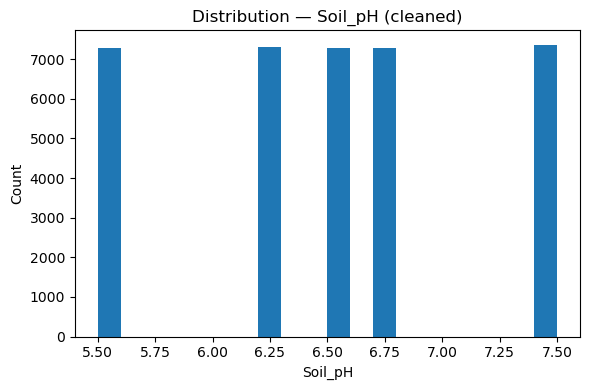

Saved: clean_outputs\dist_clean_Soil_pH.png


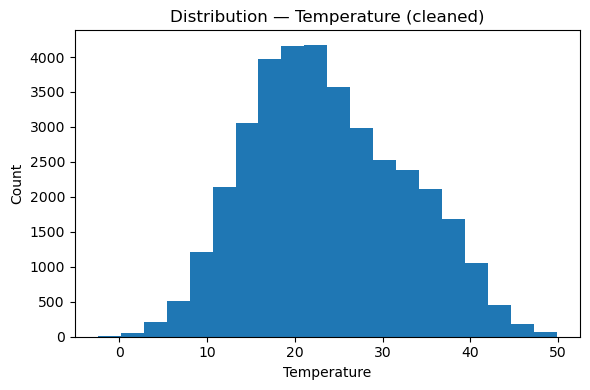

Saved: clean_outputs\dist_clean_Temperature.png


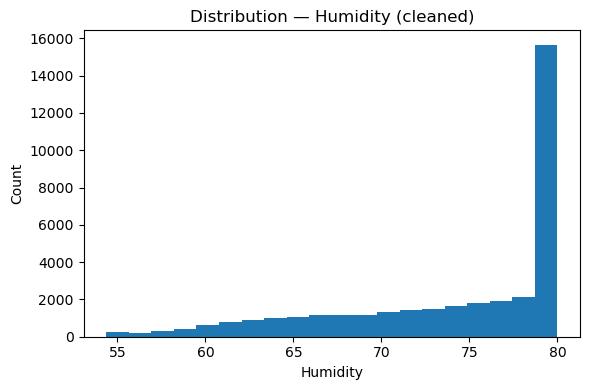

Saved: clean_outputs\dist_clean_Humidity.png


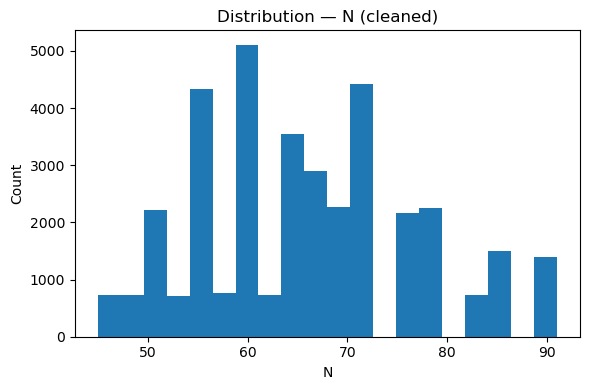

Saved: clean_outputs\dist_clean_N.png


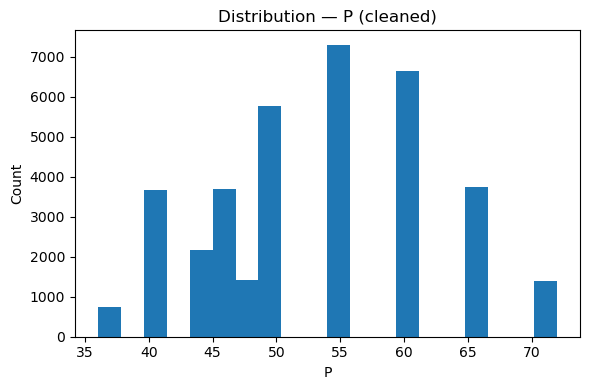

Saved: clean_outputs\dist_clean_P.png


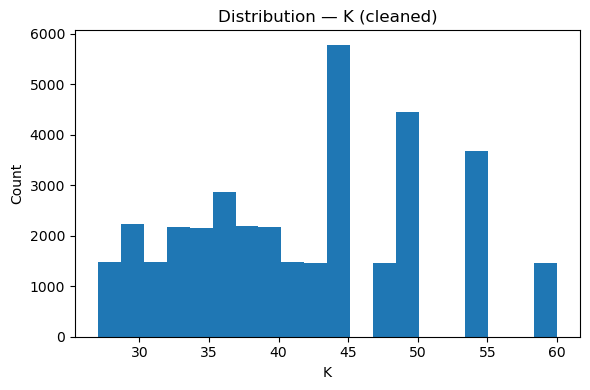

Saved: clean_outputs\dist_clean_K.png


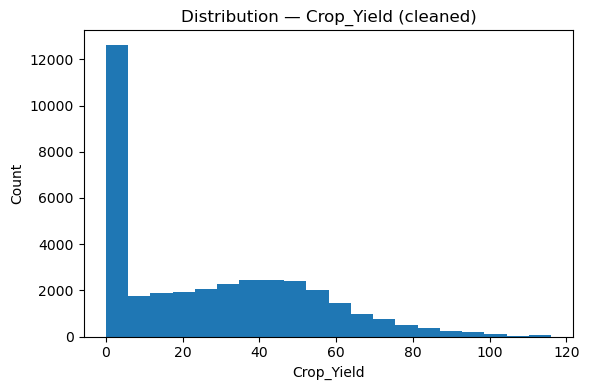

Saved: clean_outputs\dist_clean_Crop_Yield.png


In [80]:
for c in ["Soil_pH", "Temperature", "Humidity", "N", "P", "K", "Crop_Yield"]:
    if c in df.columns:
        plt.figure(figsize=(6,4))
        plt.hist(df[c], bins=20)
        plt.title(f"Distribution — {c} (cleaned)")
        plt.xlabel(c); plt.ylabel("Count")
        path = OUTDIR / f"dist_clean_{c}.png"
        plt.tight_layout(); plt.savefig(path, dpi=200); plt.show()
        print("Saved:", path)


In [82]:
df.sample(min(10, len(df)))


,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
20197,2019-07-13,tomato,peaty,5.50,36.536519,63.463481,10.758823,55.0,40.5,35.0,0.000000,21.750000
24231,2020-08-20,corn,loamy,6.50,41.338013,58.661987,13.887119,84.0,66.0,50.0,0.000000,66.666667
5142,2015-05-30,rice,loamy,6.50,26.128806,73.871194,8.637162,91.0,72.0,55.0,116.039323,72.666667
18827,2019-02-26,tomato,sandy,6.75,15.352599,80.000000,12.854530,50.0,36.0,30.0,1.933982,33.833333
27653,2021-07-28,barley,sandy,6.75,32.115460,67.884540,9.414678,50.0,40.0,30.0,0.000000,35.000000
8680,2016-05-18,wheat,clay,6.25,25.450892,74.549108,4.135232,66.0,50.0,36.0,35.387590,44.333333
35780,2023-10-19,wheat,sandy,6.75,18.395448,80.000000,6.774765,55.0,40.0,27.0,49.004678,35.583333
6636,2015-10-26,sugarcane,loamy,6.50,25.835133,74.164867,14.492682,91.0,72.0,60.0,104.623089,74.333333
13855,2017-10-17,cotton,saline,7.50,21.677333,78.322667,14.868024,71.5,60.5,54.0,53.356942,15.500000
6611,2015-10-24,corn,peaty,5.50,12.571723,80.000000,9.586272,66.0,49.5,35.0,15.045716,25.083333


In [84]:

rice_df = df[df["Crop_Type"].str.contains(CROP_NAME, na=False)].copy()
if rice_df.empty:
    base = df.copy()
    scope = "entire dataset (no rice rows found)"
else:
    base = rice_df.copy()
    scope = "rows where Crop_Type is rice"
print("Scope:", scope, "| Rows used:", len(base))
base.head(10)


Scope: rows where Crop_Type is rice | Rows used: 3652


,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
2,2014-01-01,rice,peaty,5.50,12.143099,80.0,7.227751,71.5,54.0,38.5,0.000000,27.333333
12,2014-01-02,rice,peaty,5.50,14.421759,80.0,9.096689,71.5,54.0,38.5,0.000000,27.333333
22,2014-01-03,rice,saline,7.50,12.327918,80.0,5.514838,84.5,66.0,49.5,0.000000,16.666667
32,2014-01-04,rice,clay,6.25,11.208364,80.0,11.372247,78.0,60.0,44.0,0.000000,53.083333
42,2014-01-05,rice,clay,6.25,15.065169,80.0,11.133309,78.0,60.0,44.0,0.566930,53.083333
52,2014-01-06,rice,loamy,6.50,15.065009,80.0,14.360602,91.0,72.0,55.0,0.689849,72.666667
62,2014-01-07,rice,saline,7.50,9.083672,80.0,11.484987,84.5,66.0,49.5,0.000000,16.666667
72,2014-01-08,rice,clay,6.25,13.403225,80.0,9.386150,78.0,60.0,44.0,0.000000,53.083333
82,2014-01-09,rice,loamy,6.50,17.507134,80.0,13.181916,91.0,72.0,55.0,25.499600,72.666667
92,2014-01-10,rice,sandy,6.75,18.409765,80.0,9.069200,65.0,48.0,33.0,24.413266,42.583333


In [86]:

present = [c for c in NUTRIENTS if c in base.columns]
means = base[present].mean(numeric_only=True)
percent = {c: (means[c] / TARGETS[c] * 100.0) if TARGETS.get(c) else np.nan for c in present}
display_names = {"N": "Nitrogen", "P": "Phosphorous", "K": "Potassium"}

summary = pd.DataFrame({
    "Nutrient": [display_names[c] for c in present],
    "Mean_Value": [means[c] for c in present],
    "Target_for_Rice": [TARGETS[c] for c in present],
    "%_of_Target": [percent[c] for c in present],
    "Scope": [scope]*len(present)
})
summary_path = OUTDIR / "rice_soil_nutrient_summary.csv"
summary.to_csv(summary_path, index=False)
summary


,Nutrient,Mean_Value,Target_for_Rice,%_of_Target,Scope
0,Nitrogen,77.864732,90.0,86.516369,rows where Crop_Type is rice
1,Phosphorous,59.875137,40.0,149.687842,rows where Crop_Type is rice
2,Potassium,43.885542,40.0,109.713855,rows where Crop_Type is rice


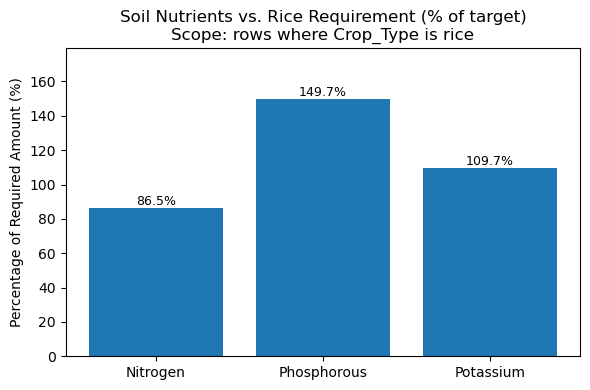

Saved bar chart to: clean_outputs\rice_soil_nutrient_bar.png


In [88]:

# Bar chart (matplotlib, single plot, no custom colors/styles)
plt.figure(figsize=(6,4))
bars = plt.bar(summary["Nutrient"], summary["%_of_Target"])
plt.ylabel("Percentage of Required Amount (%)")
plt.title("Soil Nutrients vs. Rice Requirement (% of target)\nScope: " + scope)
top = float(np.nanmax(summary["%_of_Target"])) if len(summary) else 100
plt.ylim(0, max(120, top * 1.2))
for rect, val in zip(bars, summary["%_of_Target"]):
    h = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, h, f"{val:.1f}%", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
bar_path = OUTDIR / "rice_soil_nutrient_bar.png"
plt.savefig(bar_path, dpi=200)
plt.show()
print("Saved bar chart to:", bar_path)


In [90]:

eda_summary_path = OUTDIR / "eda_summary_stats.csv"
base.describe(include="all").to_csv(eda_summary_path)
print("Saved summary stats CSV to:", eda_summary_path)
base.describe(include="all")


Saved summary stats CSV to: clean_outputs\eda_summary_stats.csv


,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
count,3652,3652,3652,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
unique,NaN,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,rice,clay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,3652,768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2018-12-31 12:00:00,NaN,NaN,6.494592,23.781319,74.306692,10.032299,77.864732,59.875137,43.885542,28.678204,42.143278
min,2014-01-01 00:00:00,NaN,NaN,5.500000,-2.266770,54.363130,1.912466,65.000000,48.000000,33.000000,0.000000,16.666667
25%,2016-07-01 18:00:00,NaN,NaN,6.250000,17.231325,69.794022,7.981693,71.500000,54.000000,38.500000,0.000000,27.333333
50%,2018-12-31 12:00:00,NaN,NaN,6.500000,22.890081,77.109919,9.979412,78.000000,60.000000,44.000000,23.332898,42.583333
75%,2021-07-01 06:00:00,NaN,NaN,6.750000,30.205978,80.000000,12.038370,84.500000,66.000000,49.500000,50.125797,53.083333
max,2023-12-31 00:00:00,NaN,NaN,7.500000,49.884058,80.000000,18.115554,91.000000,72.000000,55.000000,116.039323,72.666667


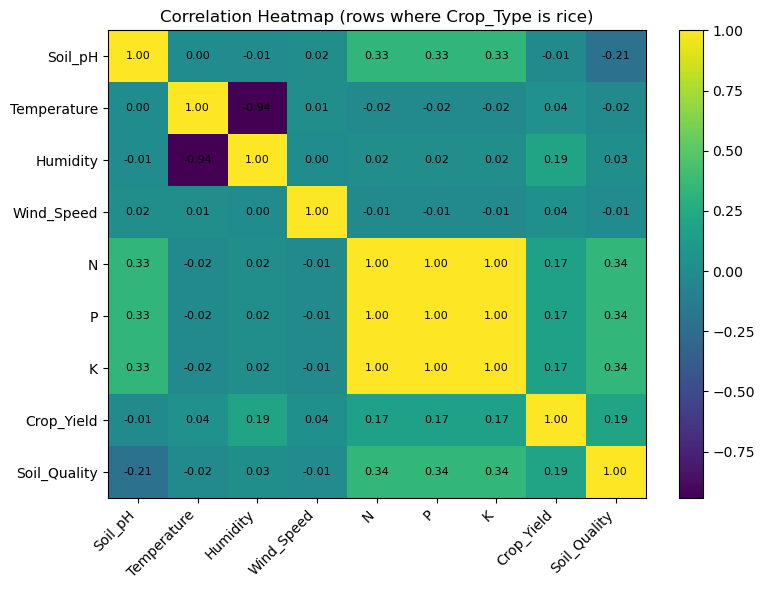

Saved heatmap to: clean_outputs\eda_corr_heatmap.png


In [92]:

num = base.select_dtypes(include=[np.number]).copy()
if num.shape[1] >= 2:
    corr = num.corr()
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr, interpolation='nearest', aspect='auto')
    plt.colorbar(im)
    plt.title(f"Correlation Heatmap ({scope})")
    ticks = np.arange(len(corr.columns))
    plt.xticks(ticks, corr.columns, rotation=45, ha='right')
    plt.yticks(ticks, corr.columns)
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)
    plt.tight_layout()
    heat_path = OUTDIR / "eda_corr_heatmap.png"
    plt.savefig(heat_path, dpi=200)
    plt.show()
    print("Saved heatmap to:", heat_path)
else:
    print("Not enough numeric columns for correlation heatmap.")


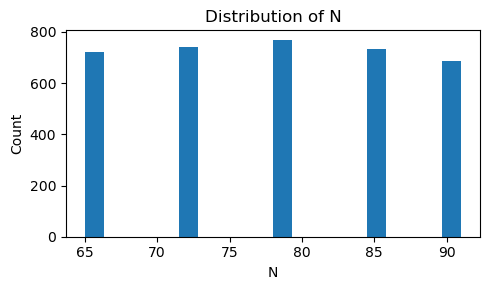

Saved distribution plot for N to: clean_outputs\eda_dist_N.png


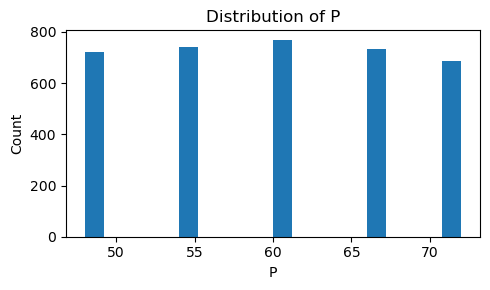

Saved distribution plot for P to: clean_outputs\eda_dist_P.png


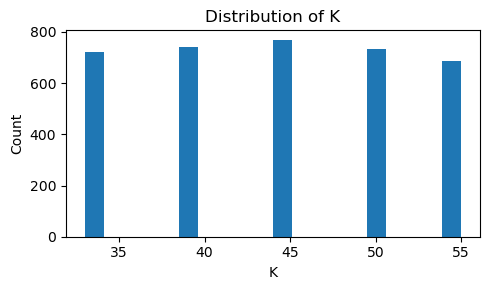

Saved distribution plot for K to: clean_outputs\eda_dist_K.png


In [94]:

for col in NUTRIENTS:
    if col in base.columns:
        series = base[col].dropna()
        if not series.empty:
            plt.figure(figsize=(5,3))
            plt.hist(series, bins=20)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col); plt.ylabel("Count")
            plt.tight_layout()
            path = OUTDIR / f"eda_dist_{col}.png"
            plt.savefig(path, dpi=200)
            plt.show()
            print(f"Saved distribution plot for {col} to:", path)


In [95]:

features = [c for c in NUMERIC_FEATURES if c in base.columns]
cat_feats = [c for c in CATEGORICAL_FEATURES if c in base.columns]
assert TARGET in base.columns, f"Expected target column '{TARGET}' not found."

X_all = base[features + cat_feats + [TARGET]].dropna().copy()
y_all = X_all[TARGET].values
X_all = X_all.drop(columns=[TARGET])

print("Feature columns:", features + cat_feats)
print("Rows used for ML:", len(X_all))
X_all.head()


Feature columns: ['N', 'P', 'K', 'Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'Soil_Type']
Rows used for ML: 3652


,N,P,K,Soil_pH,Temperature,Humidity,Wind_Speed,Soil_Type
2,71.5,54.0,38.5,5.50,12.143099,80.0,7.227751,peaty
12,71.5,54.0,38.5,5.50,14.421759,80.0,9.096689,peaty
22,84.5,66.0,49.5,7.50,12.327918,80.0,5.514838,saline
32,78.0,60.0,44.0,6.25,11.208364,80.0,11.372247,clay
42,78.0,60.0,44.0,6.25,15.065169,80.0,11.133309,clay


In [98]:

def eval_regression(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False)
    }

transformers = []
if features:
    transformers.append(("num", "passthrough", features))
if cat_feats:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats))
preproc = ColumnTransformer(transformers)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
}

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

results = []
preds = pd.DataFrame(index=np.arange(len(y_test)))
for name, est in models.items():
    pipe = Pipeline([("preproc", preproc), ("model", est)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    metrics = eval_regression(y_test, y_pred)
    results.append({"Model": name, **metrics})
    preds[name] = y_pred

    # coefficients / importances
    if hasattr(preproc, "get_feature_names_out"):
        feat_names = preproc.get_feature_names_out()
    else:
        feat_names = np.array(features + cat_feats)

    if name == "LinearRegression":
        coefs = pipe.named_steps["model"].coef_
        lr_coef_df = pd.DataFrame({"Feature": feat_names, "Coefficient": coefs})
        lr_coef_df.to_csv(OUTDIR / "lr_coefficients.csv", index=False)
    elif name == "RandomForest":
        imps = pipe.named_steps["model"].feature_importances_
        rf_imp_df = pd.DataFrame({"Feature": feat_names, "Importance": imps}).sort_values("Importance", ascending=False)
        rf_imp_df.to_csv(OUTDIR / "rf_feature_importances.csv", index=False)

metrics_df = pd.DataFrame(results)
metrics_df.to_csv(OUTDIR / "model_metrics.csv", index=False)
preds["y_true"] = y_test
preds.to_csv(OUTDIR / "model_predictions.csv", index=False)

metrics_df


C:\Users\mniti\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mniti\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,R2,MAE,RMSE
0,LinearRegression,0.546942,15.877314,19.388803
1,RandomForest,0.976923,2.568623,4.375893



## Next Steps
- Tune Random Forest hyperparameters (e.g., `max_depth`, `min_samples_leaf`) or try **XGBoost/LightGBM**.
- Add interaction features like **N:P ratio** or **pH × K**.
- Stratify by **Soil_Type** or bin **Soil_pH** for targeted models.
- Validate with **k-fold cross-validation** and compare models robustly.


In [101]:
def eval_summary(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False)
    }

def kfold_report(model, X, y, preproc=None, cv=5, scoring=("r2","neg_mean_absolute_error","neg_root_mean_squared_error"), model_name="Model"):
    pipe = Pipeline([("preproc", preproc)] + ([("model", model)] if preproc else [("model", model)]))
    cvres = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)
    df = pd.DataFrame({
        "Model":[model_name],
        "CV_R2_mean":[cvres["test_r2"].mean()],
        "CV_R2_std":[cvres["test_r2"].std()],
        "CV_MAE_mean":[(-cvres["test_neg_mean_absolute_error"]).mean()],
        "CV_RMSE_mean":[(-cvres["test_neg_root_mean_squared_error"]).mean()]
    })
    return df

# Optional: XGBoost / LightGBM if available
try:
    from xgboost import XGBRegressor
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False

try:
    from lightgbm import LGBMRegressor
    HAVE_LGBM = True
except Exception:
    HAVE_LGBM = False

print("Have XGBoost:", HAVE_XGB, "| Have LightGBM:", HAVE_LGBM)


Have XGBoost: False | Have LightGBM: False


In [103]:
# === Build interaction features on top of your 'base' DataFrame ===
work = base.copy()

# Add safely (avoid div-by-zero)
if all(c in work.columns for c in ["N","P"]):
    work["N_over_P"] = work["N"] / work["P"].replace(0, np.nan)
    work["N_over_P"] = work["N_over_P"].fillna(0)

if all(c in work.columns for c in ["Soil_pH","K"]):
    work["pH_times_K"] = work["Soil_pH"] * work["K"]

# Optional: simple quadratic terms (uncomment if desired)
# for col in ["N","P","K","Soil_pH","Temperature","Humidity","Wind_Speed"]:
#     if col in work.columns:
#         work[f"{col}2"] = work[col]**2

print("New columns:", [c for c in work.columns if c not in base.columns])
work.head(3)


New columns: ['N_over_P', 'pH_times_K']


,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality,N_over_P,pH_times_K
2,2014-01-01,rice,peaty,5.5,12.143099,80.0,7.227751,71.5,54.0,38.5,0.0,27.333333,1.324074,211.75
12,2014-01-02,rice,peaty,5.5,14.421759,80.0,9.096689,71.5,54.0,38.5,0.0,27.333333,1.324074,211.75
22,2014-01-03,rice,saline,7.5,12.327918,80.0,5.514838,84.5,66.0,49.5,0.0,16.666667,1.280303,371.25


In [104]:
# === Soil_pH binning for targeted models & as categorical feature ===
if "Soil_pH" in work.columns:
    work["pH_bin"] = pd.cut(work["Soil_pH"],
                            bins=[-np.inf, 5.5, 6.5, 7.5, np.inf],
                            labels=["acidic","slightly_acidic","neutral","alkaline"])
else:
    work["pH_bin"] = "unknown"

# Define features and target
TARGET = "Crop_Yield"
num_feats = [c for c in ["N","P","K","Soil_pH","Temperature","Humidity","Wind_Speed","N_over_P","pH_times_K"] if c in work.columns]
cat_feats = [c for c in ["Soil_Type","pH_bin"] if c in work.columns]

# Drop NA rows touching selected columns
Z = work[num_feats + cat_feats + [TARGET]].dropna().copy()
y = Z[TARGET].values
X = Z.drop(columns=[TARGET])

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)
print("Rows used:", len(X))
X.head(3)


Numeric features: ['N', 'P', 'K', 'Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N_over_P', 'pH_times_K']
Categorical features: ['Soil_Type', 'pH_bin']
Rows used: 3652


,N,P,K,Soil_pH,Temperature,Humidity,Wind_Speed,N_over_P,pH_times_K,Soil_Type,pH_bin
2,71.5,54.0,38.5,5.5,12.143099,80.0,7.227751,1.324074,211.75,peaty,acidic
12,71.5,54.0,38.5,5.5,14.421759,80.0,9.096689,1.324074,211.75,peaty,acidic
22,84.5,66.0,49.5,7.5,12.327918,80.0,5.514838,1.280303,371.25,saline,neutral


In [107]:
# === Random Forest tuning with k-fold CV (fixed for sklearn >= 1.3) ===

# Preprocessor (same features you defined earlier)
preproc = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_feats),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
    ]
)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# NOTE: removed 'auto' from max_features (invalid in recent sklearn)
param_dist = {
    "model__n_estimators": [200, 300, 500, 800],
    "model__max_depth": [None, 6, 8, 12, 16, 24],
    "model__min_samples_leaf": [1, 2, 3, 5, 8, 12],
    "model__min_samples_split": [2, 4, 6, 10],
    # valid options only:
    "model__max_features": ["sqrt", "log2", None, 0.3, 0.5, 0.8],
    # optional:
    # "model__bootstrap": [True, False]
}

pipe = Pipeline([("preproc", preproc), ("model", rf)])

# Safer CV split for small datasets
n_splits = 5 if len(X) >= 50 else max(3, min(5, len(X)//10 if len(X)//10 >= 2 else 3))
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=25,
    cv=cv,
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score="raise"  # surface errors instead of silently setting NaN
)

search.fit(X, y)

print("Best RF params:", search.best_params_)
print("Best CV R2:", search.best_score_)

# Cross-validated summary for the tuned model (uses your kfold_report helper)
rf_tuned = search.best_estimator_
rf_cv_df = kfold_report(
    rf_tuned.named_steps["model"],
    X, y,
    preproc=preproc,
    cv=n_splits,
    model_name="RandomForest_Tuned"
)
rf_cv_df


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best RF params: {'model__n_estimators': 300, 'model__min_samples_split': 4, 'model__min_samples_leaf': 8, 'model__max_features': 0.8, 'model__max_depth': 16}
Best CV R2: 0.9792058874531966


,Model,CV_R2_mean,CV_R2_std,CV_MAE_mean,CV_RMSE_mean
0,RandomForest_Tuned,0.978788,0.002093,2.399233,4.11224


In [108]:
results = []

# Linear Regression (baseline)
lr = LinearRegression()
lr_df = kfold_report(lr, X, y, preproc=preproc, cv=5, model_name="LinearRegression")
results.append(lr_df)

# RandomForest (default)
rf_default = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_def_df = kfold_report(rf_default, X, y, preproc=preproc, cv=5, model_name="RandomForest_300")
results.append(rf_def_df)

# RandomForest (tuned from previous cell)
try:
    results.append(rf_cv_df)
except NameError:
    pass  # if tuning cell wasn't run

# XGBoost (if available)
if HAVE_XGB:
    xgb = XGBRegressor(
        n_estimators=600, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1
    )
    xgb_df = kfold_report(xgb, X, y, preproc=preproc, cv=5, model_name="XGBoost")
    results.append(xgb_df)

# LightGBM (if available)
if HAVE_LGBM:
    lgbm = LGBMRegressor(
        n_estimators=800, learning_rate=0.05,
        num_leaves=31, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1
    )
    lgbm_df = kfold_report(lgbm, X, y, preproc=preproc, cv=5, model_name="LightGBM")
    results.append(lgbm_df)

compare_df = pd.concat(results, ignore_index=True)
compare_df.to_csv(OUTDIR / "model_comparison_kfold.csv", index=False)
compare_df.sort_values("CV_R2_mean", ascending=False)


,Model,CV_R2_mean,CV_R2_std,CV_MAE_mean,CV_RMSE_mean
2,RandomForest_Tuned,0.978788,0.002093,2.399233,4.112240
1,RandomForest_300,0.975655,0.001435,2.531861,4.409915
0,LinearRegression,0.542431,0.019488,15.661196,19.124738


In [109]:
# === Train a separate tuned RF per Soil_Type and compare ===
if "Soil_Type" in Z.columns and Z["Soil_Type"].nunique() > 1:
    per_type_rows = []
    for stype, part in Z.groupby("Soil_Type"):
        Xp = part.drop(columns=[TARGET])
        yp = part[TARGET].values
        if len(part) < 30:  # skip tiny splits to avoid unreliable CV
            continue

        preproc_st = ColumnTransformer(
            transformers=[
                ("num", "passthrough", [c for c in num_feats if c in Xp.columns]),
                ("cat", OneHotEncoder(handle_unknown="ignore"), [c for c in cat_feats if c in Xp.columns])
            ]
        )
        rf_local = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
        df_st = kfold_report(rf_local, Xp, yp, preproc=preproc_st, cv=5, model_name=f"RF_{stype}")
        df_st.insert(0, "Soil_Type", stype)
        per_type_rows.append(df_st)

    if per_type_rows:
        soiltype_compare = pd.concat(per_type_rows, ignore_index=True)
        soiltype_compare.to_csv(OUTDIR / "per_soiltype_rf_kfold.csv", index=False)
        soiltype_compare.sort_values(["CV_R2_mean"], ascending=False)
        print(soiltype_compare)
    else:
        print("Not enough rows per Soil_Type for meaningful CV.")
else:
    print("Soil_Type not available or single category only; skipping per-type models.")


  Soil_Type      Model  CV_R2_mean  CV_R2_std  CV_MAE_mean  CV_RMSE_mean
0      clay    RF_clay    0.975645   0.003332     2.600180      4.522290
1     loamy   RF_loamy    0.971152   0.004771     3.838861      6.275334
2     peaty   RF_peaty    0.969872   0.001613     2.230602      3.827633
3    saline  RF_saline    0.975283   0.002661     2.208734      3.792685
4     sandy   RF_sandy    0.977371   0.005216     2.084890      3.411674


In [110]:
# === Train a RF within each pH_bin ===
if "pH_bin" in Z.columns and Z["pH_bin"].nunique() > 1:
    per_bin_rows = []
    for pbin, part in Z.groupby("pH_bin"):
        Xp = part.drop(columns=[TARGET])
        yp = part[TARGET].values
        if len(part) < 30:
            continue
        preproc_bin = ColumnTransformer(
            transformers=[
                ("num", "passthrough", [c for c in num_feats if c in Xp.columns]),
                ("cat", OneHotEncoder(handle_unknown="ignore"), [c for c in cat_feats if c in Xp.columns])
            ]
        )
        rf_local = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
        df_bin = kfold_report(rf_local, Xp, yp, preproc=preproc_bin, cv=5, model_name=f"RF_pH_{pbin}")
        df_bin.insert(0, "pH_bin", str(pbin))
        per_bin_rows.append(df_bin)

    if per_bin_rows:
        phbin_compare = pd.concat(per_bin_rows, ignore_index=True)
        phbin_compare.to_csv(OUTDIR / "per_phbin_rf_kfold.csv", index=False)
        phbin_compare.sort_values(["CV_R2_mean"], ascending=False)
        print(phbin_compare)
    else:
        print("Not enough rows per pH_bin for meaningful CV.")
else:
    print("pH_bin not available or single bin only; skipping per-bin models.")


C:\Users\mniti\AppData\Local\Temp\ipykernel_14880\2035487268.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for pbin, part in Z.groupby("pH_bin"):


            pH_bin                  Model  CV_R2_mean  CV_R2_std  CV_MAE_mean  \
0           acidic           RF_pH_acidic    0.969872   0.001613     2.230602   
1  slightly_acidic  RF_pH_slightly_acidic    0.974294   0.001498     3.164600   
2          neutral          RF_pH_neutral    0.976643   0.001634     2.120214   

   CV_RMSE_mean  
0      3.827633  
1      5.397642  
2      3.592734  


In [111]:
# Load from variable if present; else from CSV
try:
    _st_df = soiltype_compare.copy()
except NameError:
    csv_path = OUTDIR / "per_soiltype_rf_kfold.csv"
    if not csv_path.exists():
        raise FileNotFoundError(
            "per_soiltype_rf_kfold.csv not found and 'soiltype_compare' not in memory. "
            "Run the per-Soil_Type training cell first."
        )
    _st_df = pd.read_csv(csv_path)

# Sort for nicer plotting
_st_df = _st_df.sort_values("CV_R2_mean", ascending=False)

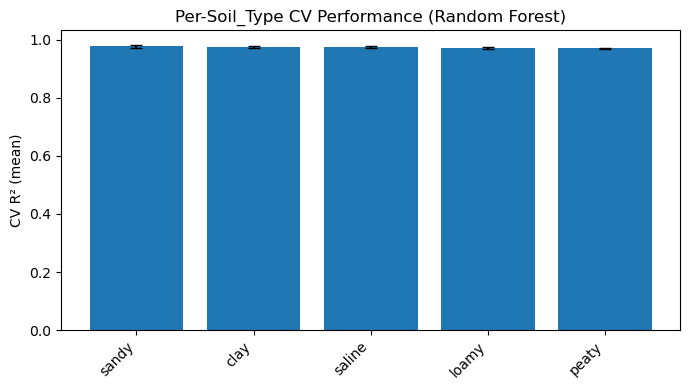

Saved: clean_outputs\viz_per_soiltype_cv_r2.png


In [112]:
# ----- Plot 1: CV R2 (mean ± std) by Soil_Type -----
plt.figure(figsize=(7, 4))
x = np.arange(len(_st_df))
plt.bar(x, _st_df["CV_R2_mean"], yerr=_st_df.get("CV_R2_std", None), capsize=4)
plt.xticks(x, _st_df["Soil_Type"], rotation=45, ha="right")
plt.ylabel("CV R² (mean)")
plt.title("Per-Soil_Type CV Performance (Random Forest)")
plt.tight_layout()
out_r2 = OUTDIR / "viz_per_soiltype_cv_r2.png"
plt.savefig(out_r2, dpi=200)
plt.show()
print("Saved:", out_r2)

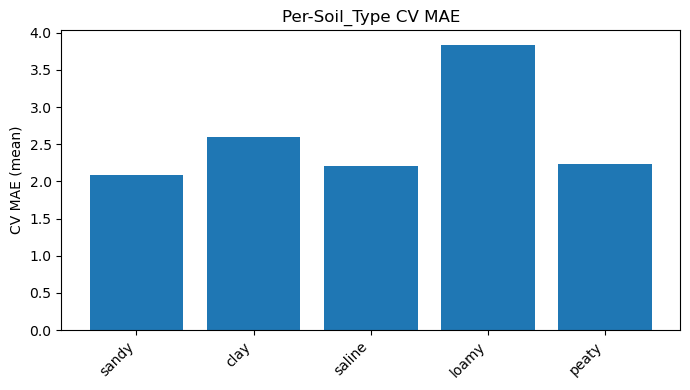

Saved: clean_outputs\viz_per_soiltype_cv_mae.png


In [113]:
# ----- Plot 2: CV MAE (mean) by Soil_Type -----
if "CV_MAE_mean" in _st_df.columns:
    plt.figure(figsize=(7, 4))
    x = np.arange(len(_st_df))
    plt.bar(x, _st_df["CV_MAE_mean"])
    plt.xticks(x, _st_df["Soil_Type"], rotation=45, ha="right")
    plt.ylabel("CV MAE (mean)")
    plt.title("Per-Soil_Type CV MAE")
    plt.tight_layout()
    out_mae = OUTDIR / "viz_per_soiltype_cv_mae.png"
    plt.savefig(out_mae, dpi=200)
    plt.show()
    print("Saved:", out_mae)

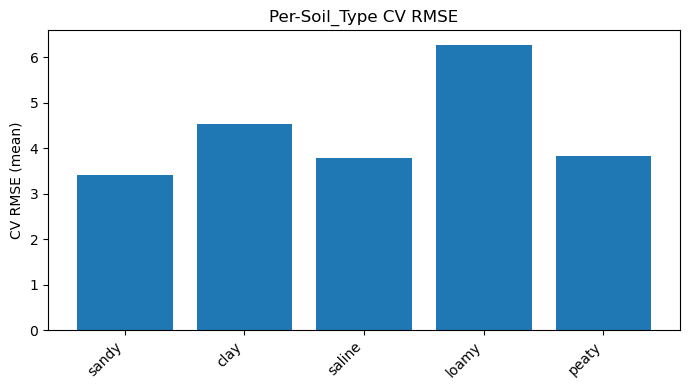

Saved: clean_outputs\viz_per_soiltype_cv_rmse.png


In [114]:
# ----- Plot 3: CV RMSE (mean) by Soil_Type -----
if "CV_RMSE_mean" in _st_df.columns:
    plt.figure(figsize=(7, 4))
    x = np.arange(len(_st_df))
    plt.bar(x, _st_df["CV_RMSE_mean"])
    plt.xticks(x, _st_df["Soil_Type"], rotation=45, ha="right")
    plt.ylabel("CV RMSE (mean)")
    plt.title("Per-Soil_Type CV RMSE")
    plt.tight_layout()
    out_rmse = OUTDIR / "viz_per_soiltype_cv_rmse.png"
    plt.savefig(out_rmse, dpi=200)
    plt.show()
    print("Saved:", out_rmse)

In [115]:
# Load from variable if present; else from CSV
try:
    _ph_df = phbin_compare.copy()
except NameError:
    csv_path = OUTDIR / "per_phbin_rf_kfold.csv"
    if not csv_path.exists():
        raise FileNotFoundError(
            "per_phbin_rf_kfold.csv not found and 'phbin_compare' not in memory. "
            "Run the per-pH_bin training cell first."
        )
    _ph_df = pd.read_csv(csv_path)

# Ensure pH_bin is string (for labels) and sort by CV_R2_mean
_ph_df["pH_bin"] = _ph_df["pH_bin"].astype(str)
_ph_df = _ph_df.sort_values("CV_R2_mean", ascending=False)

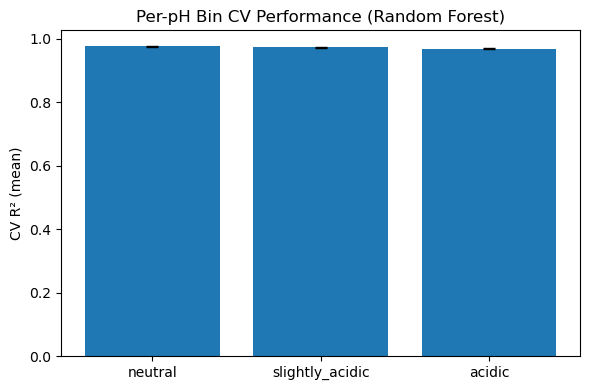

Saved: clean_outputs\viz_per_phbin_cv_r2.png


In [116]:
# ----- Plot 1: CV R2 (mean ± std) by pH_bin -----
plt.figure(figsize=(6, 4))
x = np.arange(len(_ph_df))
plt.bar(x, _ph_df["CV_R2_mean"], yerr=_ph_df.get("CV_R2_std", None), capsize=4)
plt.xticks(x, _ph_df["pH_bin"], rotation=0)
plt.ylabel("CV R² (mean)")
plt.title("Per-pH Bin CV Performance (Random Forest)")
plt.tight_layout()
out_r2 = OUTDIR / "viz_per_phbin_cv_r2.png"
plt.savefig(out_r2, dpi=200)
plt.show()
print("Saved:", out_r2)

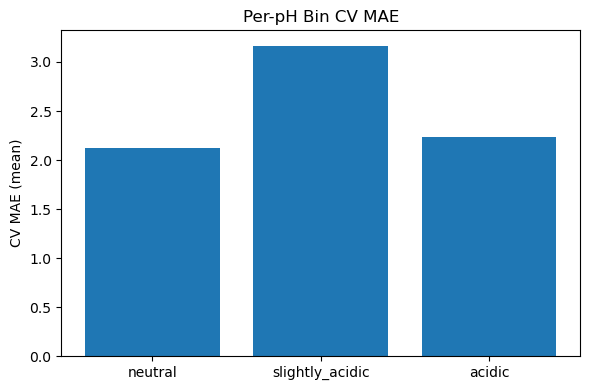

Saved: clean_outputs\viz_per_phbin_cv_mae.png


In [117]:
# ----- Plot 2: CV MAE (mean) by pH_bin -----
if "CV_MAE_mean" in _ph_df.columns:
    plt.figure(figsize=(6, 4))
    x = np.arange(len(_ph_df))
    plt.bar(x, _ph_df["CV_MAE_mean"])
    plt.xticks(x, _ph_df["pH_bin"])
    plt.ylabel("CV MAE (mean)")
    plt.title("Per-pH Bin CV MAE")
    plt.tight_layout()
    out_mae = OUTDIR / "viz_per_phbin_cv_mae.png"
    plt.savefig(out_mae, dpi=200)
    plt.show()
    print("Saved:", out_mae)

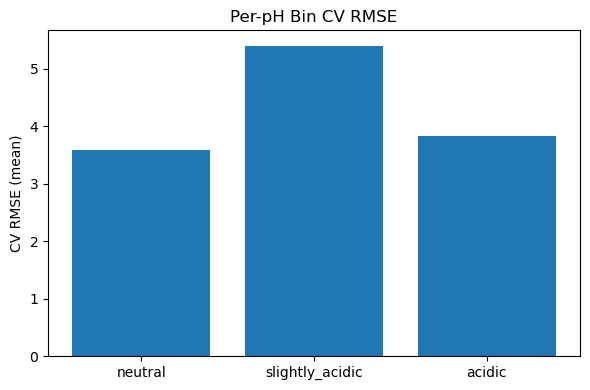

Saved: clean_outputs\viz_per_phbin_cv_rmse.png


In [118]:
# ----- Plot 3: CV RMSE (mean) by pH_bin -----
if "CV_RMSE_mean" in _ph_df.columns:
    plt.figure(figsize=(6, 4))
    x = np.arange(len(_ph_df))
    plt.bar(x, _ph_df["CV_RMSE_mean"])
    plt.xticks(x, _ph_df["pH_bin"])
    plt.ylabel("CV RMSE (mean)")
    plt.title("Per-pH Bin CV RMSE")
    plt.tight_layout()
    out_rmse = OUTDIR / "viz_per_phbin_cv_rmse.png"
    plt.savefig(out_rmse, dpi=200)
    plt.show()
    print("Saved:", out_rmse)